I dati coprono il periodo da 2004-03-10 (hour=18) a 2005-02-28 (hour=23), e sono storicizzati nel file CSV in fondo.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Seed value
# Apparently you may use different seed values at each stage
seed_value= 0

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()


#import tensorflow as tf
#tf.random.set_seed(seed_value)




# for later versions: 
# tf.compat.v1.set_random_seed(seed_value)

# 5. Configure a new global `tensorflow` session
from keras import backend as K
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)
# for later versions:
# session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
# sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
# tf.compat.v1.keras.backend.set_session(sess)


Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
import numpy as np
np.random.seed(1028)
import os
import numpy as np
import pickle
import tensorflow as tf
import random  as rm
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM, GRU
from sklearn.metrics import mean_absolute_error
import math 
from datetime import datetime, timedelta


import time
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import seaborn as sns
from dateutil.parser import parse 
import matplotlib as mpl
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from keras.models import Sequential
from keras.layers import Dense, Dropout, TimeDistributed
from keras.layers import LSTM, GRU
#from keras.utils import set_random_seed
plt.style.use('seaborn-pastel')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
tf.keras.utils.set_random_seed(3) #7

In [3]:
os.chdir("/content/drive/MyDrive/SDM&TSA")
!ls

 812503_20220108.csv		 modelli_ML.ipynb
'Copia di LSTM-Copy1.ipynb'	 modelli_ML_nuovi.ipynb
 data_linear_with_ts.csv	 preprocessing.ipynb
 data_set_missung.csv		'Project_data_2021_2022 (TRAINSET).csv'
 data_with_ts.csv		'SDM&TSA_presentation.gslides'
 dati_completi.csv		'sdm&tsa_report_Emanuele_Marnati_812503.gdoc'
 imputed_ts.csv			'sdm&tsa_report.gdoc'
 LSTM.csv			 ts.csv
 modelli_ML_definititivo.ipynb


In [ ]:
!pwd

/content/drive/My Drive/SDM&TSA


In [4]:
data = pd.read_csv('ts.csv', parse_dates=['Datetime'])

In [5]:
data

,Datetime,CO
0,2004-03-10 18:00:00,1360.0
1,2004-03-10 19:00:00,1292.0
2,2004-03-10 20:00:00,1402.0
3,2004-03-10 21:00:00,1376.0
4,2004-03-10 22:00:00,1272.0
...,...,...
8521,2005-02-28 19:00:00,938.0
8522,2005-02-28 20:00:00,939.0
8523,2005-02-28 21:00:00,827.0
8524,2005-02-28 22:00:00,776.0


In [6]:
def predict(num_prediction, model):
  prediction_list = dataset[-look_back:]

  for _ in range(num_prediction):
    x = prediction_list[-look_back:]
    x = x.reshape((1,1,look_back))
    out = model.predict(x)[0][0]
    prediction_list = np.append(prediction_list, out)
  prediction_list = prediction_list[look_back:]

  return prediction_list

In [7]:
def create_dataset(dataset, look_back=1):
  dataX, dataY = [], []
  for i in range(len(dataset) - look_back-1):
    a = dataset[i:(i+look_back), 0]
    dataX.append(a)
    dataY.append(dataset[i + look_back, 0])
  return np.array(dataX), np.array(dataY)

In [8]:
def MAPE(Y_actual, Y_Predicted):
  mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
  return mape

In [9]:
ts = data[['Datetime', 'CO']].set_index('Datetime')
ts

,CO
Datetime,
2004-03-10 18:00:00,1360.0
2004-03-10 19:00:00,1292.0
2004-03-10 20:00:00,1402.0
2004-03-10 21:00:00,1376.0
2004-03-10 22:00:00,1272.0
...,...
2005-02-28 19:00:00,938.0
2005-02-28 20:00:00,939.0
2005-02-28 21:00:00,827.0


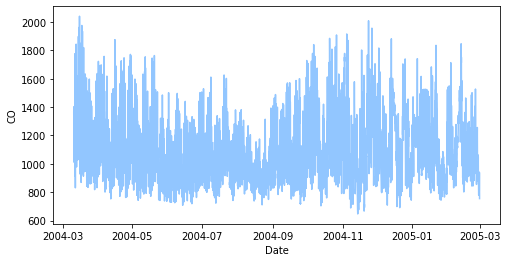

In [10]:
plt.figure(figsize=(8,4))
plt.xlabel('Date')
plt.ylabel('CO')
plt.plot(ts)

In [ ]:
#ts.to_csv('ts.csv')

# LSTM

In [11]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(ts)

In [12]:
train, test = dataset[0:6821, :], dataset[6821:len(dataset),:]

In [13]:
len(train), len(test)

(6821, 1705)

In [ ]:
24*14

336

In [ ]:
look_back = 24*14
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [ ]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [ ]:
#np.random.seed(123) 
model = Sequential()
model.add(GRU(300, input_shape= (1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer = 'adam')
model.fit(trainX, trainY, epochs=10, batch_size = 10, verbose= 1)

Epoch 1/10
649/649 [==============================] - 8s 8ms/step - loss: 0.0134
Epoch 2/10
649/649 [==============================] - 5s 8ms/step - loss: 0.0053
Epoch 3/10
649/649 [==============================] - 5s 8ms/step - loss: 0.0049
Epoch 4/10
649/649 [==============================] - 5s 8ms/step - loss: 0.0043
Epoch 5/10
649/649 [==============================] - 5s 8ms/step - loss: 0.0042
Epoch 6/10
649/649 [==============================] - 5s 7ms/step - loss: 0.0038
Epoch 7/10
649/649 [==============================] - 5s 7ms/step - loss: 0.0038
Epoch 8/10
649/649 [==============================] - 5s 8ms/step - loss: 0.0038
Epoch 9/10
649/649 [==============================] - 5s 8ms/step - loss: 0.0037
Epoch 10/10
649/649 [==============================] - 5s 8ms/step - loss: 0.0034


In [ ]:
trainY

array([0.44005743, 0.61306533, 0.44938981, ..., 0.46374731, 0.50681981,
       0.43575018])

In [ ]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [ ]:
trainScore = MAPE(trainY[0], trainPredict[:,0])
print('train score: %.2f MAPE' % (trainScore))

train score: 8.74 MAPE


In [ ]:
testScore = MAPE(testY[0], testPredict[:,0])
print('test score: %.2f MAPE' % (testScore))

test score: 9.27 MAPE


In [ ]:
testY

array([[1266.40325684, 1265.52828399, 1238.52490861, ...,  939.        ,
         827.        ,  776.        ]])

In [ ]:
testPredict

array([[1333.8291 ],
       [1310.7665 ],
       [1282.4832 ],
       ...,
       [1044.2281 ],
       [ 935.8348 ],
       [ 847.43585]], dtype=float32)

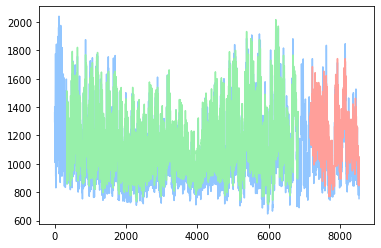

In [ ]:
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

testPredictPlot = np.empty_like(dataset)
testPredictPlot[:,:]= np.nan
testPredictPlot[len(trainPredict) + (look_back*2)+1:len(dataset)-1, :] = testPredict

plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [ ]:
from keras.layers import LeakyReLU
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(ts)
train, test = dataset[0:6821, :], dataset[6821:len(dataset),:]
look_back = 24*14
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))


model = Sequential()
model.add(GRU(300, input_shape = (1, look_back))) 
#model.add(Dropout(0.2))
model.add(Dense(1))
model.add(LeakyReLU())
model.compile( loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=10, batch_size=20, verbose=1, shuffle=False)
#model.reset_states()
#model.summary()

Train on 6484 samples
Epoch 1/10
6484/6484 [==============================] - 3s 417us/sample - loss: 0.0440
Epoch 2/10
6484/6484 [==============================] - 2s 285us/sample - loss: 0.0156
Epoch 3/10
6484/6484 [==============================] - 2s 268us/sample - loss: 0.0124
Epoch 4/10
6484/6484 [==============================] - 2s 261us/sample - loss: 0.0106
Epoch 5/10
6484/6484 [==============================] - 2s 265us/sample - loss: 0.0097
Epoch 6/10
6484/6484 [==============================] - 2s 258us/sample - loss: 0.0092
Epoch 7/10
6484/6484 [==============================] - 2s 254us/sample - loss: 0.0089
Epoch 8/10
6484/6484 [==============================] - 2s 266us/sample - loss: 0.0086
Epoch 9/10
6484/6484 [==============================] - 2s 270us/sample - loss: 0.0084
Epoch 10/10
6484/6484 [==============================] - 2s 255us/sample - loss: 0.0081


In [ ]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
#leggermente peggiore dell'originale
trainScore = MAPE(trainY[0], trainPredict[:,0])
print('train score: %.2f MAPE' % (trainScore))
testScore = MAPE(testY[0], testPredict[:,0])
print('test score: %.2f MAPE' % (testScore))

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


train score: 9.14 MAPE
test score: 9.68 MAPE


In [ ]:
model = Sequential()
model.add(LSTM(300, input_shape= (1, look_back)))
model.add(LeakyReLU())
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer = 'adam')
model.fit(trainX, trainY, epochs=10, batch_size = 10, verbose= 1)

# GRU

In [202]:
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(ts)

In [203]:
train, test = dataset[0:6821, :], dataset[6821:len(dataset), :]
print(len(train), len(test))

6821 1705


In [204]:
look_back = 24
trainX, trainY = create_dataset(train, look_back)
testX , testY = create_dataset(test, look_back)

In [205]:
#se riranni non va bene
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [206]:
model = Sequential()
model.add(GRU(4, input_shape = (1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer = 'adam')
model.fit(trainX, trainY, epochs=10, batch_size=10, verbose= 1)

Epoch 1/10
680/680 [==============================] - 4s 3ms/step - loss: 0.0257
Epoch 2/10
680/680 [==============================] - 2s 3ms/step - loss: 0.0082
Epoch 3/10
680/680 [==============================] - 2s 3ms/step - loss: 0.0067
Epoch 4/10
680/680 [==============================] - 2s 3ms/step - loss: 0.0059
Epoch 5/10
680/680 [==============================] - 2s 3ms/step - loss: 0.0052
Epoch 6/10
680/680 [==============================] - 2s 3ms/step - loss: 0.0047
Epoch 7/10
680/680 [==============================] - 2s 3ms/step - loss: 0.0044
Epoch 8/10
680/680 [==============================] - 2s 3ms/step - loss: 0.0043
Epoch 9/10
680/680 [==============================] - 2s 3ms/step - loss: 0.0042
Epoch 10/10
680/680 [==============================] - 2s 3ms/step - loss: 0.0041


In [207]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [208]:
trainScore = MAPE(trainY[0], trainPredict[:,0])
print('train score: %.2f MAPE' % (trainScore))

train score: 6.17 MAPE


In [209]:
testScore = MAPE(testY[0], testPredict[:,0])
print('test score: %.2f MAPE' % (testScore))

test score: 5.88 MAPE


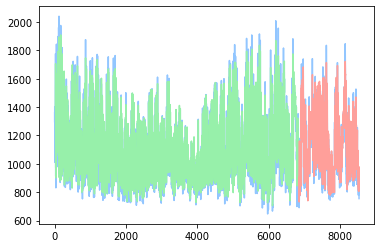

In [210]:
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

testPredictPlot = np.empty_like(dataset)
testPredictPlot[:,:]= np.nan
testPredictPlot[len(trainPredict) + (look_back*2)+1:len(dataset)-1, :] = testPredict

plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)EmanueIstantanea_2022-01-17_20-20-20.png
le


plt.plot(testPredictPlot)
plt.show()

# previsioni finali

In [648]:
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(ts)

In [649]:
train = dataset

In [650]:
look_back = 366*12

In [651]:
trainX, trainY = create_dataset(train, look_back)

In [652]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))

In [653]:

# VARIAZIONI SUL TEMA:
#model.add(Dropout(0.5))
#model.add(Dense(1,activation='sigmoid'))
#model.summary()
 


model = Sequential()
model.add(GRU(4, input_shape = (1, look_back)))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='mean_squared_error', optimizer = 'adam')
model.fit(trainX, trainY, epochs=10, batch_size=5, verbose= 1)

Epoch 1/10
827/827 [==============================] - 5s 3ms/step - loss: 0.0184
Epoch 2/10
827/827 [==============================] - 3s 4ms/step - loss: 0.0111
Epoch 3/10
827/827 [==============================] - 3s 3ms/step - loss: 0.0087
Epoch 4/10
827/827 [==============================] - 3s 3ms/step - loss: 0.0079
Epoch 5/10
827/827 [==============================] - 3s 3ms/step - loss: 0.0068
Epoch 6/10
827/827 [==============================] - 3s 4ms/step - loss: 0.0062
Epoch 7/10
827/827 [==============================] - 3s 4ms/step - loss: 0.0057
Epoch 8/10
827/827 [==============================] - 3s 4ms/step - loss: 0.0055
Epoch 9/10
827/827 [==============================] - 3s 4ms/step - loss: 0.0053
Epoch 10/10
827/827 [==============================] - 3s 3ms/step - loss: 0.0047


In [654]:
trainPredict = model.predict(trainX)
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])

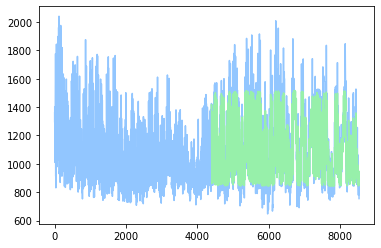

In [655]:
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.show()

In [656]:
def predict(num_prediction, model):
  prediction_list = dataset[-look_back:]

  for _ in range(num_prediction):
    x = prediction_list[-look_back:]
    x = x.reshape((1,1,look_back))
    out= model.predict(x)[0][0]
    prediction_list = np.append(prediction_list, out)
  prediction_list = prediction_list[look_back:]

  return prediction_list

In [657]:
test_datatime= pd.date_range(start='2005-03-01', end='2005-04-01', freq='H')[:-1]

In [658]:
num_prediction = len(test_datatime)
forecast = predict(num_prediction, model)


In [659]:
forecast = scaler.inverse_transform(forecast.reshape(-1,1)).flatten()

In [660]:
len(forecast)

744

In [661]:
#forecast

In [662]:
forecast = pd.DataFrame(forecast, index = test_datatime)

In [663]:
#forecast

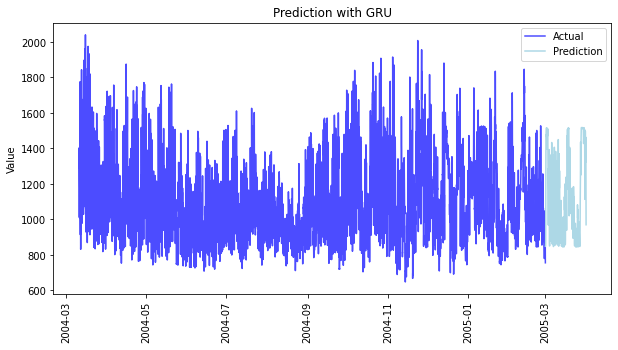

In [673]:
fig=plt.figure(figsize=(10,5))
fig.show()
ax=fig.add_subplot(111)

plt.title('Prediction with GRU')
#plt.xlabel('Date')
plt.ylabel('Value')
plt.xticks(rotation=90)

ax.plot(ts, color='blue', alpha=.7, label='Actual')
ax.plot(forecast, color='lightblue', label='Prediction')
plt.legend()
plt.show()

In [665]:
forecast.to_csv('prediction_15_new_submission.csv')

In [667]:
data_check = pd.read_csv('prediction_15_new_submission.csv')

In [668]:
data_check

,Unnamed: 0,0
0,2005-03-01 00:00:00,848.330910
1,2005-03-01 01:00:00,848.596521
2,2005-03-01 02:00:00,849.672497
3,2005-03-01 03:00:00,853.880172
4,2005-03-01 04:00:00,865.174519
...,...,...
739,2005-03-31 19:00:00,1452.827961
740,2005-03-31 20:00:00,1377.198509
741,2005-03-31 21:00:00,1219.421889
742,2005-03-31 22:00:00,1069.340214
